### Практическая работа к занятию №1

1. Попробуйте видоизменить параметры разобранной на уроке двухслойной нейронной сети таким образом, чтобы улучшить ее точность (число нейронов, число эпох , можно изменять число слоев).
2. Проведите анализ — что приводит к ухудшению точности нейронной сети? Что приводит к увеличению ее точности?

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split

#### Подготовка данных

In [3]:
# преобразование массива в бинарный вид результатов
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = Y[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j+1
    return arr

# сигмоида и ее производная
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return (x)*(1 - (x))

# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

In [4]:
iris_data = pd.read_csv("Iris.csv")

iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace=True)

# формирование входных данных
columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = pd.DataFrame(iris_data, columns=columns)
x = normalize(x.values)

# формирование выходных данных(результатов)
columns = ['Species']
y = pd.DataFrame(iris_data, columns=columns)
y = y.values
y = y.flatten()
y = to_one_hot(y)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

#### Обучение двухслойной нейронной сети

In [10]:
def plot_loss(errors):
    # loss on epoch
    plt.figure(figsize = (16,5))
    plt.plot(errors)
    plt.xlabel('Обучение')
    plt.ylabel('Ошибка')
    plt.show()

def plot_compare_train(y_pred):
    N = 50
    plt.figure(figsize = (16,5))
    plt.plot(y_pred[:N,1], 'r',label = 'Y pred')
    plt.plot(y_train[:N,1],'g', label = 'Y train')
    plt.xlabel('№ примера')
    plt.ylabel('выход сети и целевой')
    plt.legend( )
    plt.show()

def plot_compare_test(y_pred):
    N = 50
    plt.figure(figsize = (16,5))
    plt.plot(y_pred[:N,1], 'r',label = 'Y pred')
    plt.plot(y_test[:N,1],'g', label = 'Y test')
    plt.xlabel('№ примера')
    plt.ylabel('выход сети и целевой')
    plt.legend( )
    plt.show()

def train_model(neuron_numb, lr, epochs, plot_results):
    # initialize weiths
    w0 = 2*np.random.random((4, neuron_numb))
    w1 = 2*np.random.random((neuron_numb, 3))

    errors = []

    for i in range(3000):
        # прямое распространение(feed forward)
        layer0 = X_train
        layer1 = sigmoid(np.dot(layer0, w0))
        layer2 = sigmoid(np.dot(layer1, w1))

        # обратное распространение(back propagation) с использованием градиентного спуска
        layer2_error = y_train - layer2 # производная функции потерь = производная квадратичных потерь 
        layer2_delta = layer2_error * sigmoid_deriv(layer2)
        
        layer1_error = layer2_delta.dot(w1.T)
        layer1_delta = layer1_error * sigmoid_deriv(layer1)
        # коррекция
        w1 += layer1.T.dot(layer2_delta) * lr
        w0 += layer0.T.dot(layer1_delta) * lr
        # метрика модели
        error = np.mean(np.abs(layer2_error))
        errors.append(error)
        accuracy = (1 - error) * 100
    
    # Проверка на тестовой выборке
    layer0_t = X_test
    layer1_t = sigmoid(np.dot(layer0_t, w0))
    layer2_t = sigmoid(np.dot(layer1_t, w1))
    layer2_error_t = y_test - layer2_t
    error_t = np.mean(np.abs(layer2_error_t))
    accuracy_t = (1 - error_t) * 100
    
    if plot_results:
        plot_loss(errors)
        plot_compare_train(layer2)
        plot_compare_test(layer2_t)
    
    return errors, accuracy, accuracy_t

In [34]:
grid_neurons = [2, 3, 4, 5, 6, 7, 8, 9, 10]
lr = 0.05
grid_epochs = [500, 1500, 3000, 5000, 7000]

results = {}

for epochs in grid_epochs:
    for neuron_numb in grid_neurons:
        errors, accuracy, accuracy_t = train_model(neuron_numb, lr, grid_epochs,
                                                   plot_results=False)
        
        results[f"{neuron_numb}_{epochs}"] = {'errors': errors,
                                              'acc_train': accuracy,
                                              'acc_test': accuracy_t}

In [35]:
compare_metrics = pd.DataFrame.from_dict(results, orient="index",
                                         columns=['acc_train', 'acc_test'])
compare_metrics.sort_values(by='acc_train', inplace=True, ascending=False)
compare_metrics

,acc_train,acc_test
7_3000,95.326816,95.808289
8_3000,95.310227,95.790412
6_3000,95.300169,95.758818
8_5000,95.298732,95.754608
9_5000,95.286313,95.737653
10_1500,95.282417,95.736877
4_7000,95.279494,95.743690
5_7000,95.274895,95.746208
7_500,95.271056,95.755223
5_1500,95.268674,95.702134


Практически все конфигурации моделей показали хороший результат (94-96%). Худший результат показала модель с 2 нейронами в скрытом слое. По всей видимости 2 нейронов не хватает, чтобы уловить зависимость 4 признаков цветков ириса

<br>
Другие выводы:

*   все модели не переобучились. Метрики на тесте и трейне практически одинаковые.
*   большое количество эпох не всегда идет на пользу. Очевидно, что результат был бы лучше, если использовать динамический learning rate. А именно уменьшать его в процессе обучения.



Построим график функции потерь для первых 10 вариантов

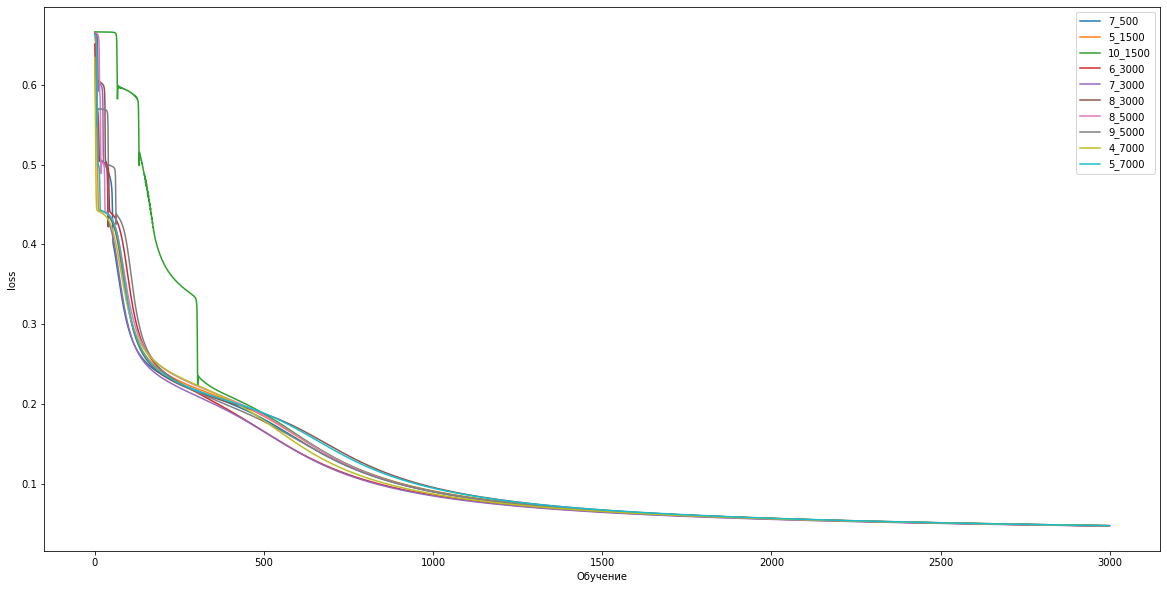

In [46]:
best_results = list(compare_metrics.index[:10])

plt.figure(figsize = (20,10))

for key, values in results.items():
    if key in best_results:
        plt.plot(values['errors'], label=key)
        plt.xlabel('Обучение')
        plt.ylabel('loss')

plt.legend()
plt.show()

Можем заметить, что все модели сходятся уже на 1500 эпохе. Далее ошибка изменяется незначительно<br>
Конфигурация 7_500 не вышла на плато, но при этом показала результат на уровне других моделей

Дополнительно отрисуем результаты обучения лучшего варианта (7_3000):

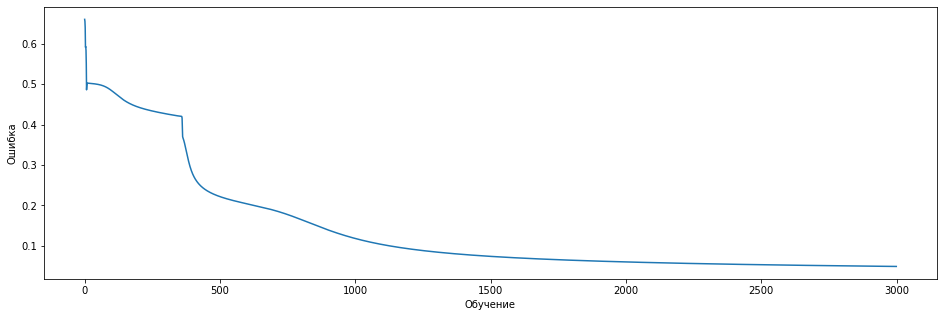

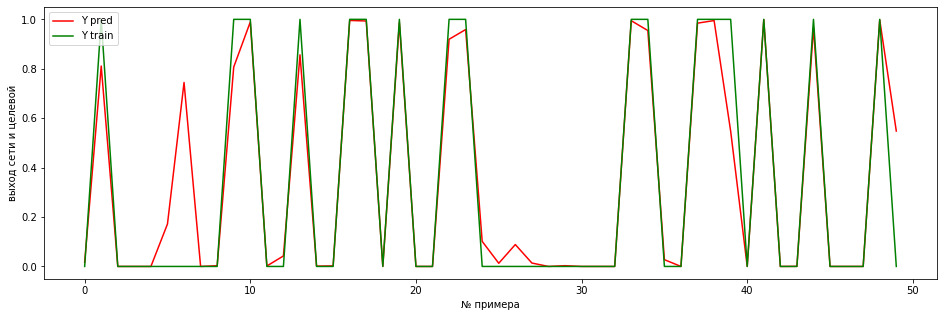

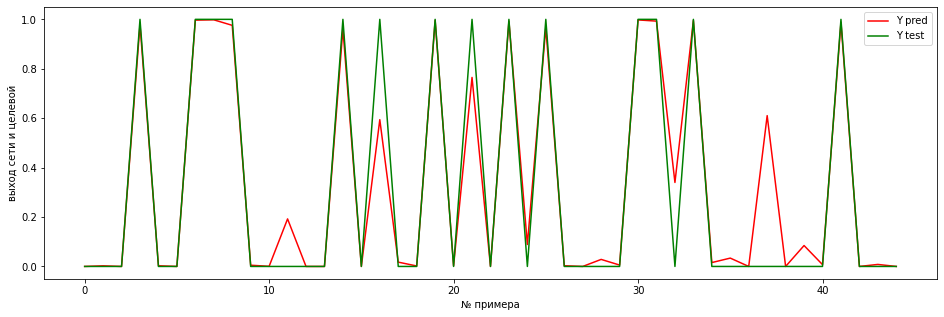

In [47]:
_ = train_model(7, 0.05, 3000, plot_results=True)